Project plan,
1. Vector autoregression
    1. Confirm stationarity using ADF
    2. Plot ACF, PACF
    3. Decomposition
    4. Create [VAR model](https://www.statsmodels.org/dev/vector_ar.html)
    5. Tests: Granger causality, residual whiteness
    6. Create impulsive response function visualization


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import altair as alt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR

In [3]:
mood = pd.read_csv('../data/emoods.csv', parse_dates=['DATE (YYYY-MM-DD)'], usecols=['DATE (YYYY-MM-DD)', 'IRRITABILITY', 'ANXIETY', 'DEPRESSED', 'ELEVATED']).rename(columns={'DATE (YYYY-MM-DD)':'date', 'IRRITABILITY':'irritable', 'ANXIETY':'anxious', 'DEPRESSED':'depressed','ELEVATED':'elevated'}).set_index('date')
sleep = pd.read_csv('../data/oura_sleep_2023-03-03T12-21-33.csv', parse_dates=['day', 'bedtime_end', 'bedtime_start']).set_index('day')
sleep_scores = pd.read_csv('../data/oura_daily-sleep_2023-03-03T12-20-39.csv', parse_dates=['day']).rename(columns={'contributors_timing':'timing', 'contributors_deep_sleep':'deep', 'contributors_restfulness':'restfulness', 'contributors_efficiency':'efficiency', 'contributors_latency':'latency','contributors_rem_sleep':'rem', 'contributors_total_sleep':'total'}).set_index('day')

In [4]:
sleep_stats = pd.DataFrame(
    columns=['Mean score','Standard deviation', 'Total nights', 'Missing nights', 'Score max', 'Score min'], 
    data=[[round(sleep_scores['score'].mean(), 2), 
           round(sleep_scores['score'].std(), 2),
           sleep_scores['score'].count(),
           sleep_scores['score'].isna().sum(),
           sleep_scores['score'].max(),
           sleep_scores['score'].min()]]
)

print(sleep_stats.T.to_latex())

\begin{tabular}{lr}
\toprule
{} &        0 \\
\midrule
Mean score         &    73.82 \\
Standard deviation &    12.36 \\
Total nights       &  1455.00 \\
Missing nights     &     1.00 \\
Score max          &    97.00 \\
Score min          &    30.00 \\
\bottomrule
\end{tabular}



/var/folders/h2/j2rcc6sn4_vcqzgfkx3nnts40000gn/T/ipykernel_99099/3794196580.py:11: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(sleep_stats.T.to_latex())


In [5]:
print(mood[mood[['irritable' ,'anxious','depressed','elevated']]>0].count().to_markdown())

|           |   0 |
|:----------|----:|
| irritable | 100 |
| anxious   |  88 |
| depressed | 103 |
| elevated  |  48 |


In [6]:
ts = sleep_scores.join(mood).join(sleep['average_hrv'])

In [7]:
ts.head(10).T

day,2019-02-05,2019-02-06,2019-02-06,2019-02-06,2019-02-06,2019-02-08,2019-02-08,2019-02-09,2019-02-09,2019-02-10
score,65.0,51.0,51.0,51.0,51.0,71.0,71.0,52.0,52.0,34.0
timing,41.0,10.0,10.0,10.0,10.0,1.0,1.0,74.0,74.0,18.0
deep,11.0,4.0,4.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0
restfulness,73.0,66.0,66.0,66.0,66.0,60.0,60.0,63.0,63.0,74.0
efficiency,98.0,96.0,96.0,96.0,96.0,83.0,83.0,96.0,96.0,55.0
latency,91.0,99.0,99.0,99.0,99.0,88.0,88.0,90.0,90.0,19.0
rem,97.0,79.0,79.0,79.0,79.0,100.0,100.0,40.0,40.0,54.0
total,59.0,34.0,34.0,34.0,34.0,100.0,100.0,35.0,35.0,23.0
irritable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
anxious,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# considering only Oura sleep score for now
test_ts = ts['score'].dropna()

# 1. Vector autoregression

## 1.1 Stationarity

In [9]:
def test_stationarity(timeseries):
    
    # set figure size
    fig = plt.figure(figsize=(18,8))
    
    #Determining rolling statistics
    rolmean = timeseries.rolling(window=7).mean() 
    rolstd = timeseries.rolling(window=7).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [10]:
from pmdarima.arima.utils import ndiffs

def test_arima(timeseries):
    Adf_Test = ndiffs(timeseries, test='adf')  
    KPSS_Test = ndiffs(timeseries, test='kpss')  
    PP_Test = ndiffs(timeseries, test='pp')  

    print('Number of differences to make stationary, via pymdarima library')
    print('ADF: ', Adf_Test, 'KPSS: ', KPSS_Test, 'PP: ', PP_Test)


### 1.1.1 Using pmdarima library

In [11]:
from pmdarima.arima.stationarity import ADFTest

print('Should we diff HRV?', ADFTest(alpha=0.05).should_diff(ts['average_hrv'].dropna()))
print('Should we diff Sleep Score?', ADFTest(alpha=0.05).should_diff(ts['score'].dropna()))

Should we diff HRV? (0.01, False)
Should we diff Sleep Score? (0.01, False)


### 1.1.2 Using statsmodels (exploratory)

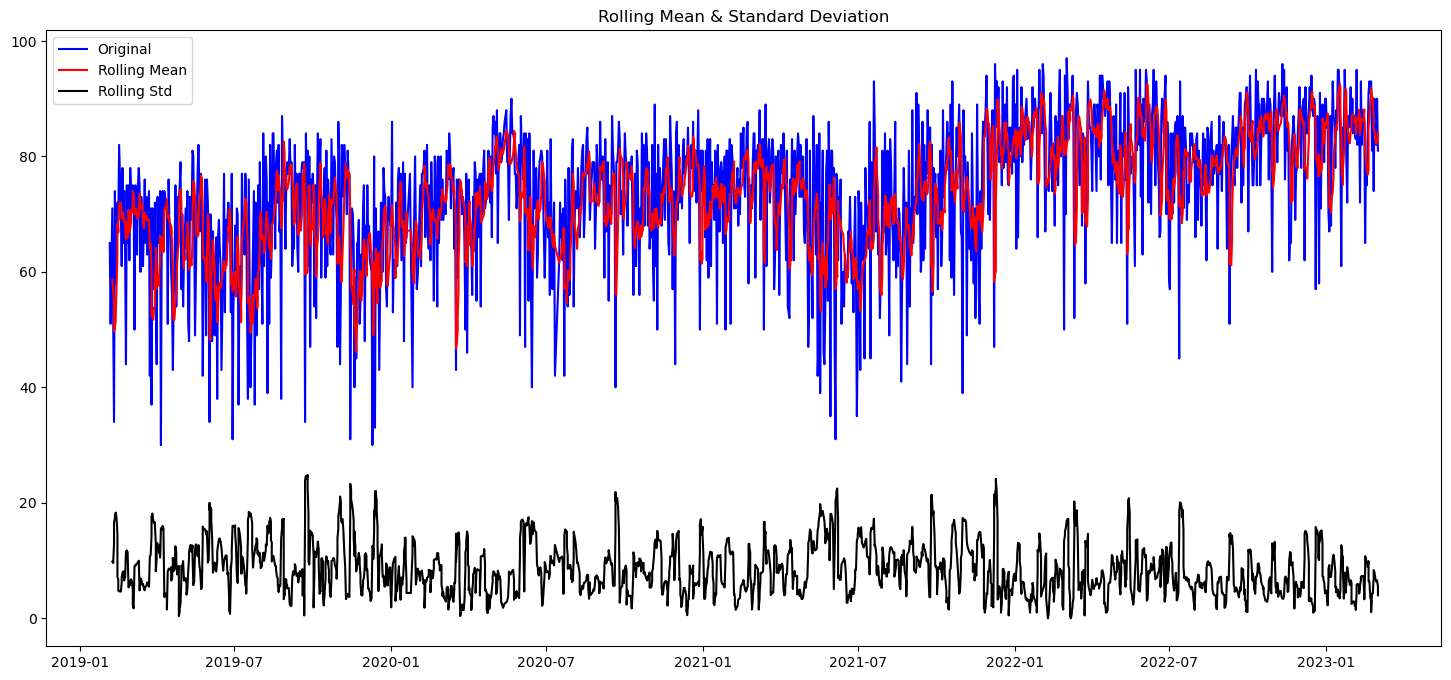

Results of Dickey-Fuller Test:
Test Statistic                   -4.026838
p-value                           0.001276
#Lags Used                       25.000000
Number of Observations Used    2516.000000
Critical Value (1%)              -3.432952
Critical Value (5%)              -2.862689
Critical Value (10%)             -2.567382
dtype: float64
Number of differences to make stationary, via pymdarima library
ADF:  0 KPSS:  1 PP:  0


In [12]:
test_stationarity(test_ts)
test_arima(test_ts)

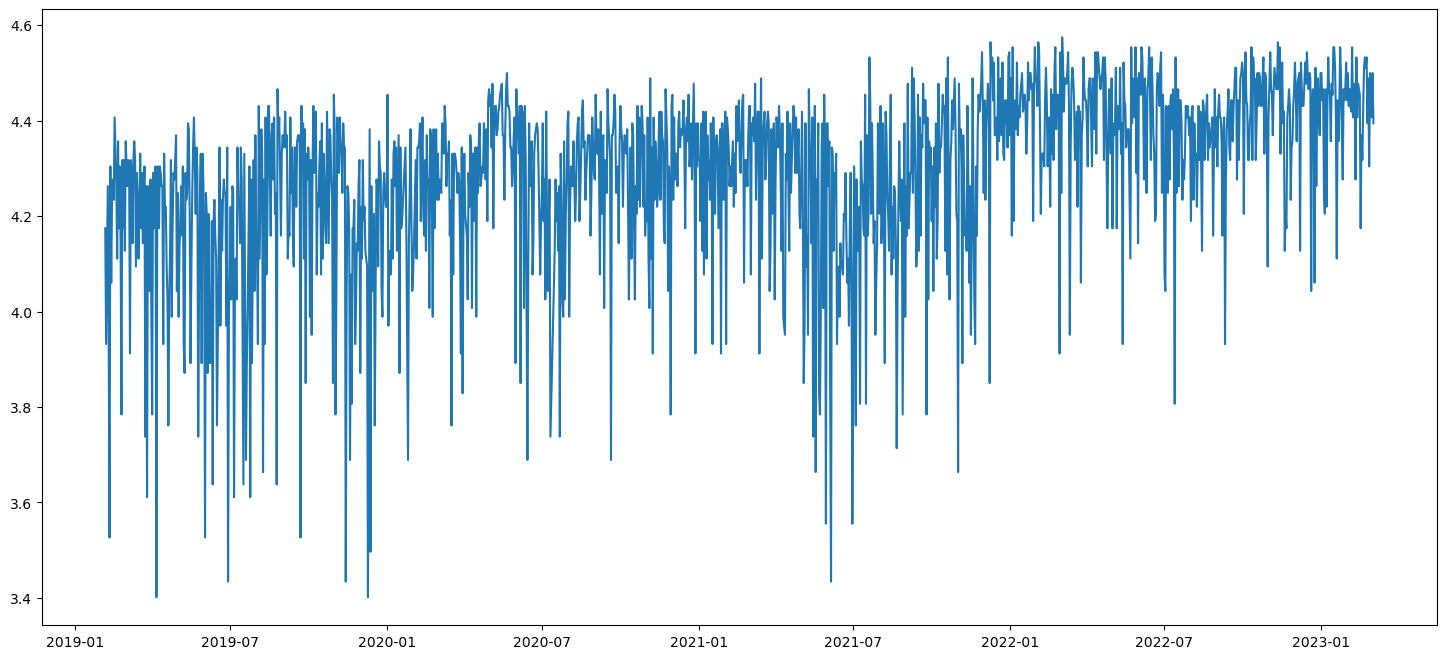

In [13]:
fig = plt.figure(figsize=(18,8))

ts_log = np.log(test_ts).dropna()
plt.plot(ts_log)

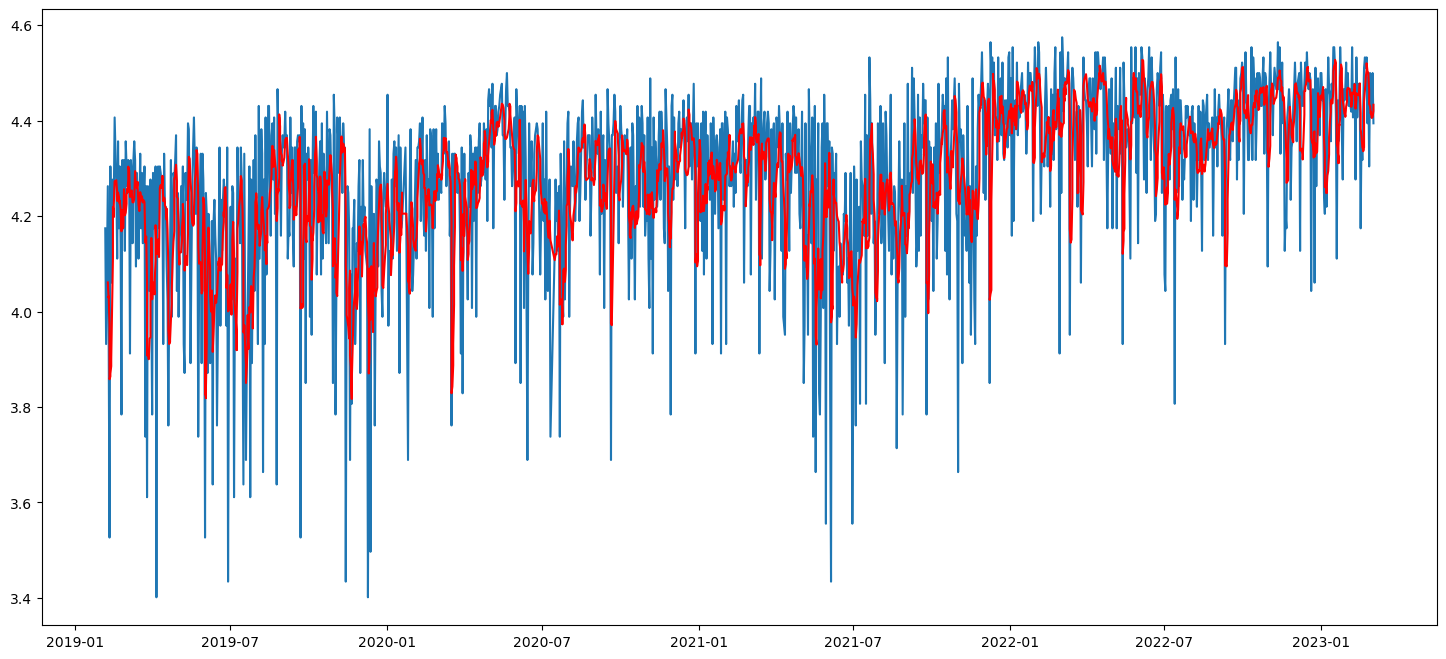

In [14]:
fig = plt.figure(figsize=(18,8))

moving_avg = ts_log.rolling(window=7).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [15]:
ts_log_moving_avg_diff = ts_log - moving_avg

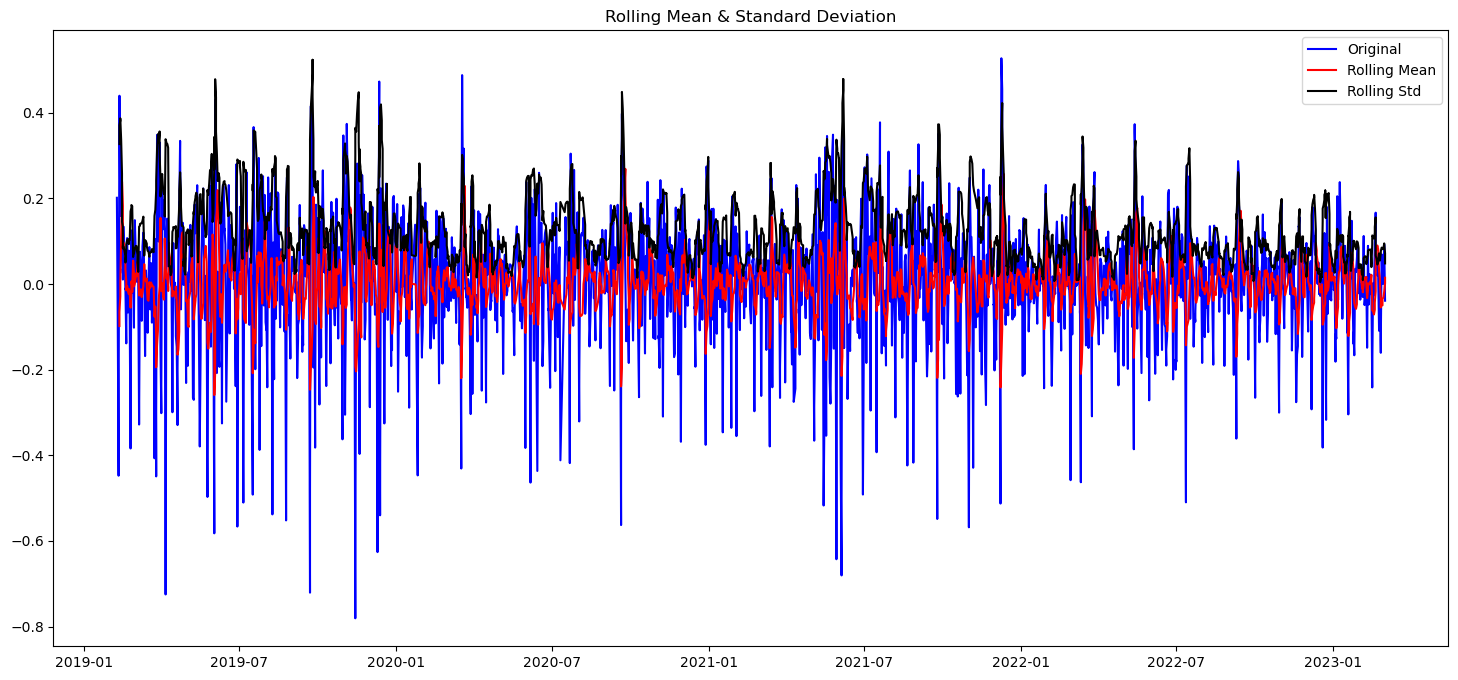

Results of Dickey-Fuller Test:
Test Statistic                -1.470353e+01
p-value                        2.921374e-27
#Lags Used                     2.700000e+01
Number of Observations Used    2.508000e+03
Critical Value (1%)           -3.432960e+00
Critical Value (5%)           -2.862693e+00
Critical Value (10%)          -2.567384e+00
dtype: float64


In [16]:
test_stationarity(ts_log_moving_avg_diff.dropna())


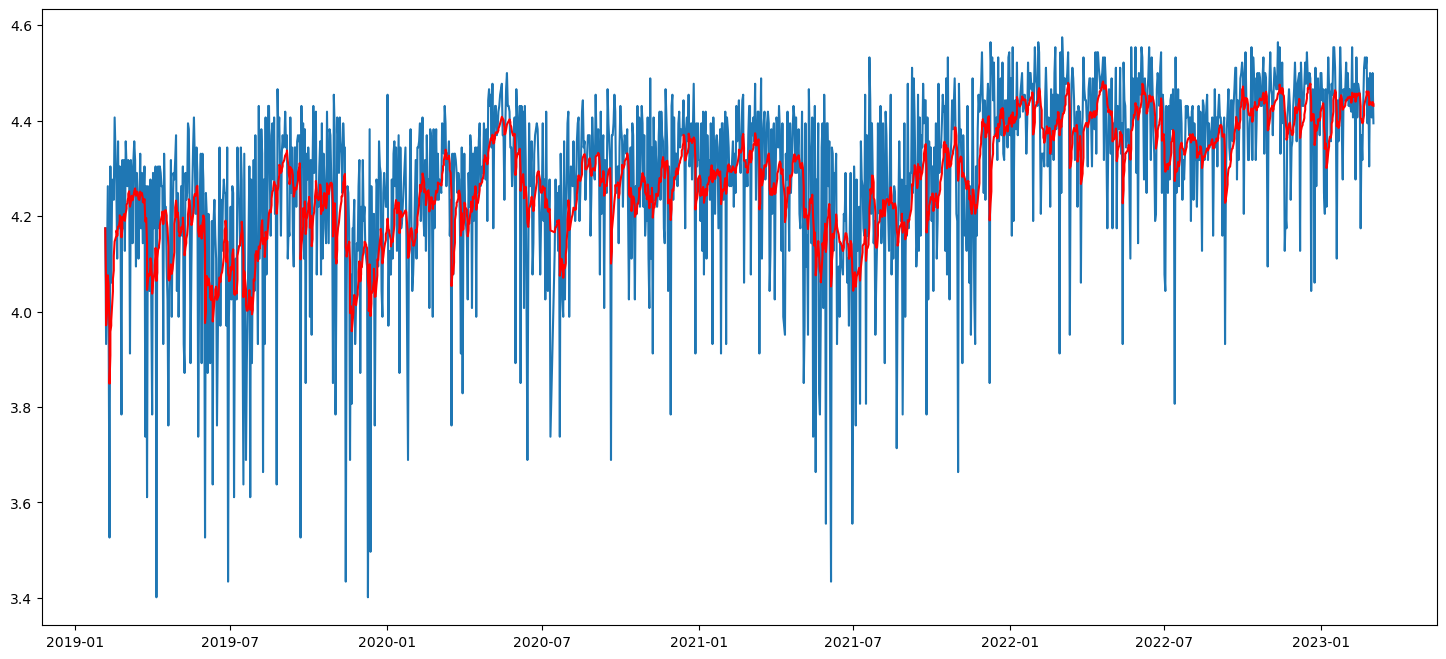

In [17]:
fig = plt.figure(figsize=(18,8))

expweighted_avg = ts_log.ewm(halflife=7).mean()
plt.plot(ts_log)
plt.plot(expweighted_avg, color='red')

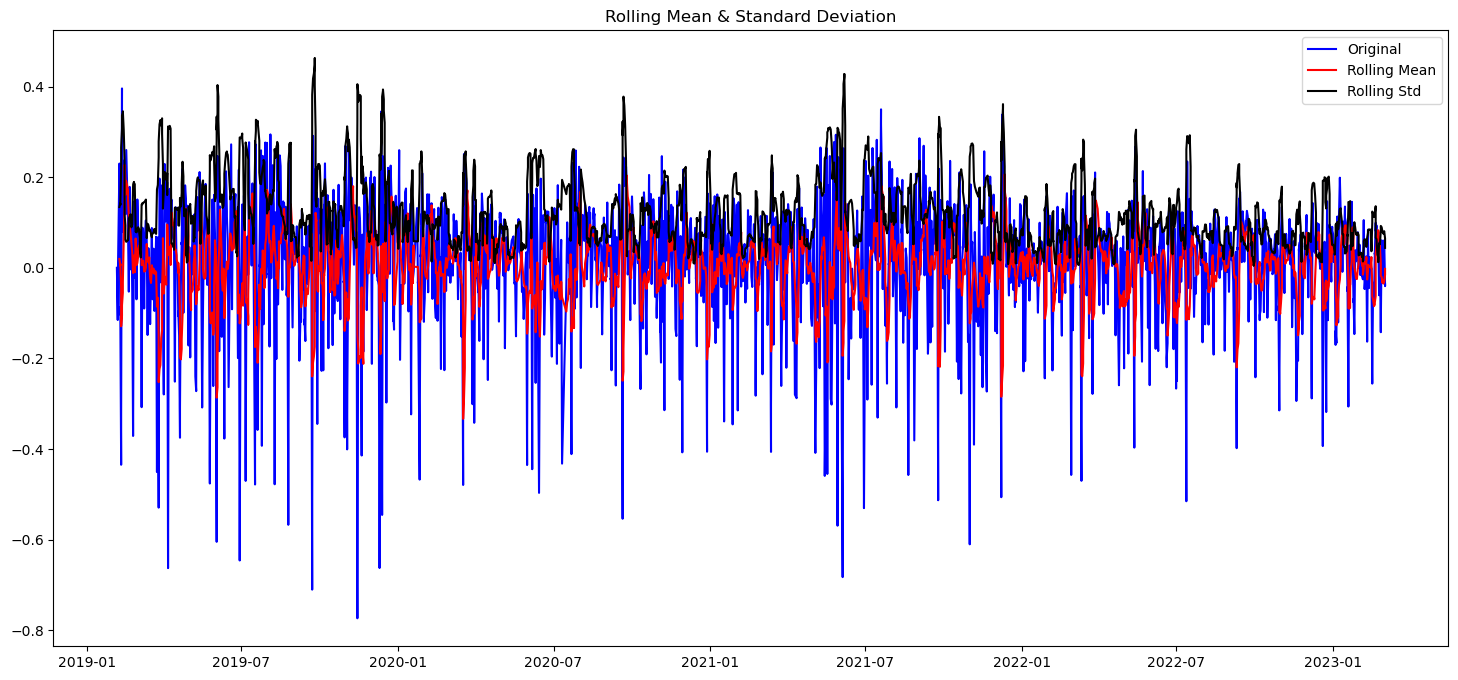

Results of Dickey-Fuller Test:
Test Statistic                  -22.202265
p-value                           0.000000
#Lags Used                        5.000000
Number of Observations Used    2536.000000
Critical Value (1%)              -3.432931
Critical Value (5%)              -2.862680
Critical Value (10%)             -2.567377
dtype: float64
Number of differences to make stationary, via pymdarima library
ADF:  0 KPSS:  1 PP:  0


In [18]:
ts_log_ewma_diff = ts_log - expweighted_avg
test_stationarity(ts_log_ewma_diff)
test_arima(test_ts)

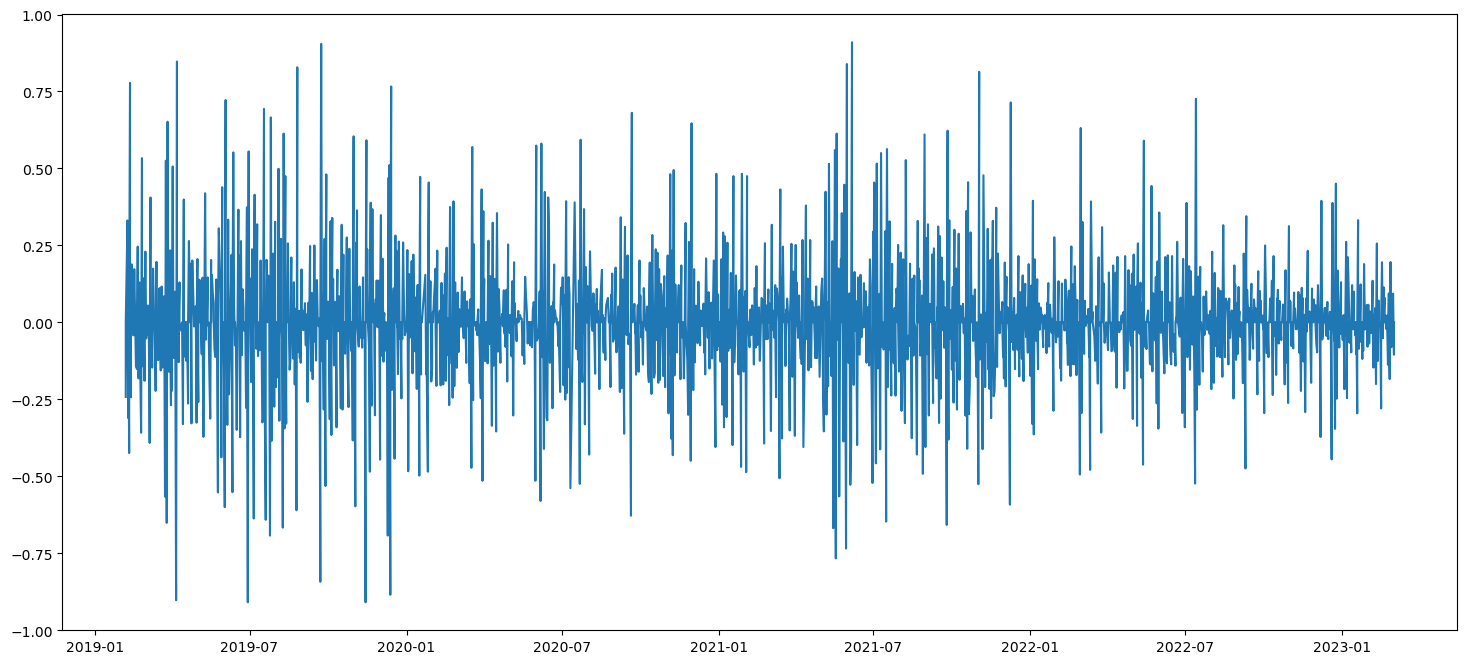

In [19]:
fig = plt.figure(figsize=(18,8))

ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

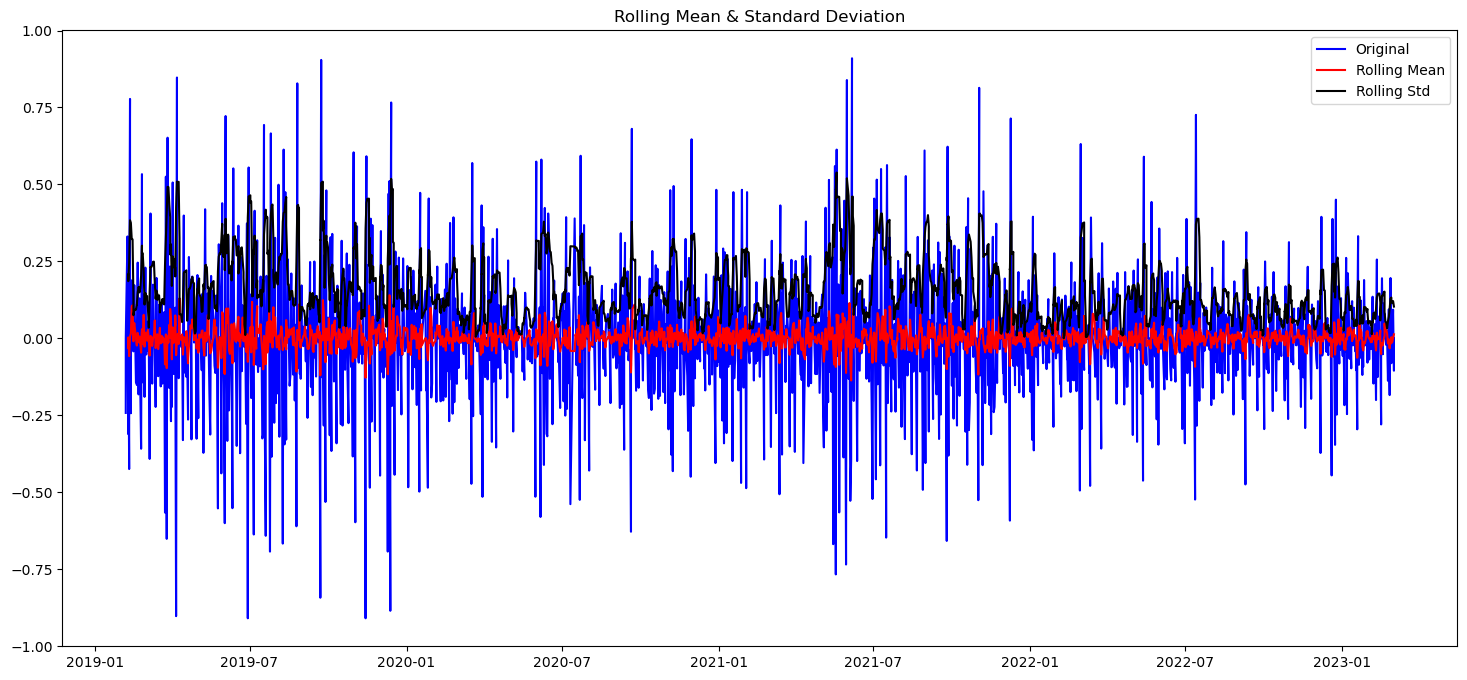

Results of Dickey-Fuller Test:
Test Statistic                -1.674920e+01
p-value                        1.338308e-29
#Lags Used                     2.400000e+01
Number of Observations Used    2.516000e+03
Critical Value (1%)           -3.432952e+00
Critical Value (5%)           -2.862689e+00
Critical Value (10%)          -2.567382e+00
dtype: float64


In [20]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

**Based on pmdarima ADF, choosing not to difference.**

## 1.2 ACF, PACF

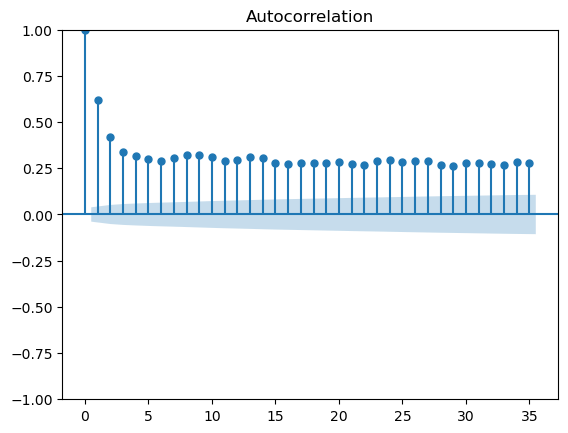

In [21]:
plot_acf(test_ts).savefig('plots/acf.png',dpi=300);

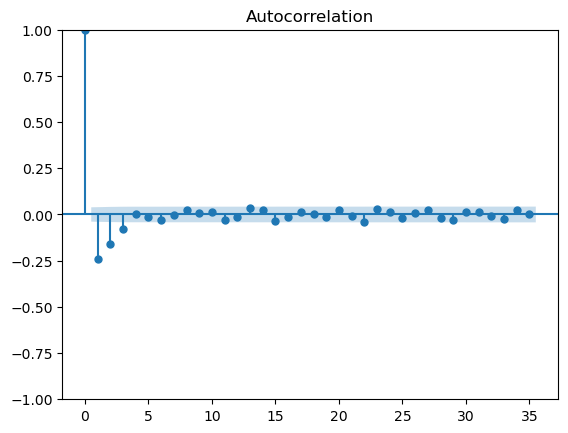

In [22]:
plot_acf(test_ts.diff(), missing='drop');

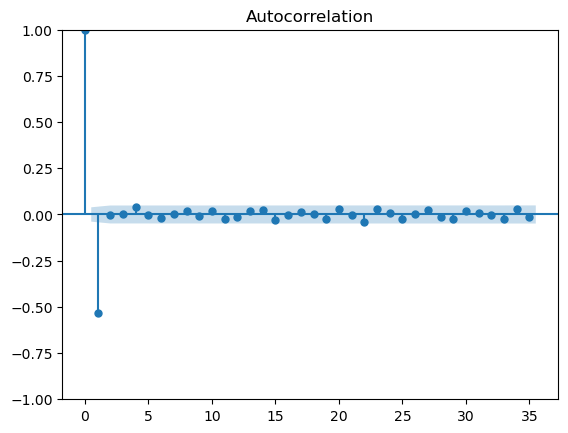

In [23]:
plot_acf(test_ts.diff().diff(), missing='drop');

/opt/homebrew/Caskroom/miniforge/base/envs/stat508_x86/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


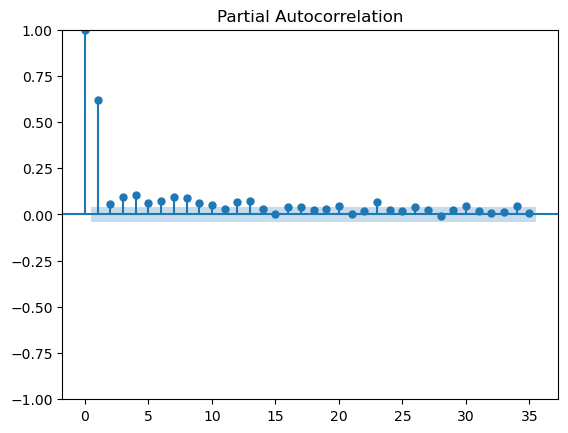

In [24]:
plot_pacf(test_ts).savefig('plots/pacf.png', dpi=300);

## 1.3 Decomposition

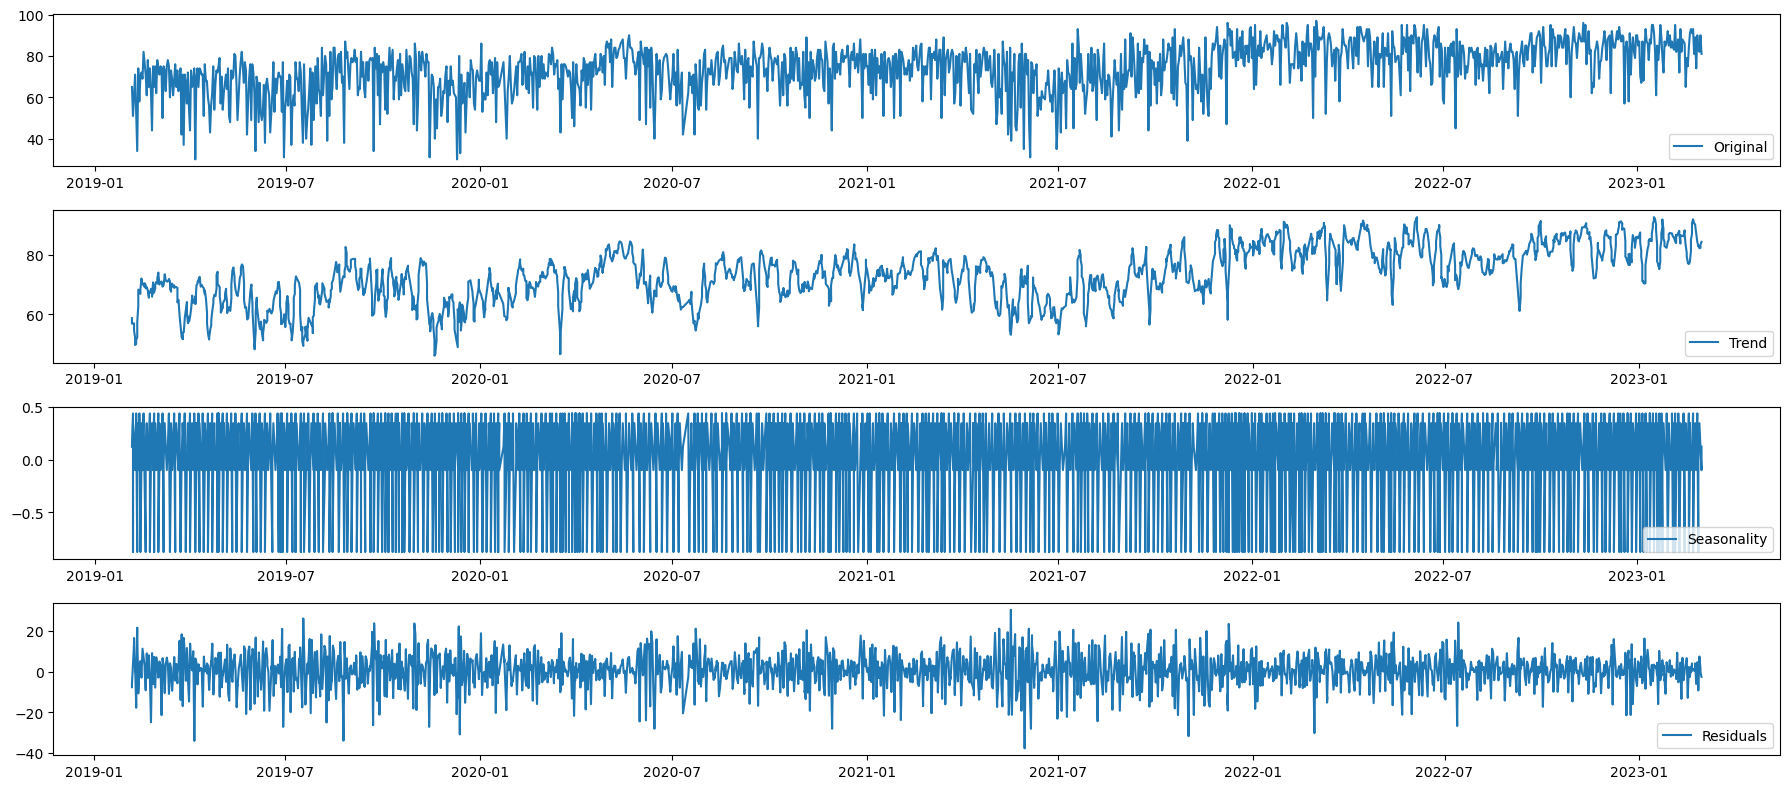

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(test_ts, period=7)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = plt.figure(figsize=(18,8))

plt.subplot(411)
plt.plot(test_ts, label='Original')
plt.legend(loc='lower right')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='lower right')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='lower right')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='lower right')
plt.tight_layout()

plt.savefig('plots/decomposition.png', dpi=300)

## 1.4 Create VAR model

In [26]:
from statsmodels.tsa.api import VAR

model_var = VAR(ts[['score', 'average_hrv', 'anxious', 'depressed', 'irritable', 'elevated']].dropna())

# lag order selection
print(model_var.select_order(15).summary().as_latex_tabular())

\begin{center}
\begin{tabular}{lcccc}
\toprule
            & \textbf{AIC} & \textbf{BIC} & \textbf{FPE} & \textbf{HQIC}  \\
\midrule
\textbf{0}  &       7.314  &       7.342  &       1501.  &        7.325   \\
\textbf{1}  &       6.080  &      6.279*  &       436.9  &       6.155*   \\
\textbf{2}  &       6.035  &       6.404  &       417.7  &        6.175   \\
\textbf{3}  &      6.028*  &       6.568  &      414.9*  &        6.233   \\
\textbf{4}  &       6.055  &       6.765  &       426.1  &        6.324   \\
\textbf{5}  &       6.056  &       6.936  &       426.6  &        6.390   \\
\textbf{6}  &       6.066  &       7.118  &       431.2  &        6.465   \\
\textbf{7}  &       6.071  &       7.293  &       433.3  &        6.534   \\
\textbf{8}  &       6.104  &       7.496  &       447.6  &        6.631   \\
\textbf{9}  &       6.131  &       7.694  &       460.4  &        6.724   \\
\textbf{10} &       6.130  &       7.863  &       459.6  &        6.787   \\
\textbf{11} &       

/opt/homebrew/Caskroom/miniforge/base/envs/stat508_x86/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [27]:
results_var = model_var.fit(3)
results_var.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 29, Apr, 2023
Time:                     16:14:14
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    6.53589
Nobs:                     1058.00    HQIC:                   6.20374
Log likelihood:          -12068.0    FPE:                    403.842
AIC:                      6.00100    Det(Omega_mle):         362.937
--------------------------------------------------------------------
Results for equation score
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                 33.675538         2.896460           11.626           0.000
L1.score               0.507601         0.031112           16.315           0.000
L1.average_hrv        -0.050172         0.022424        

## 1.6 Tests: Granger Causality, Normality

In [28]:
print(results_var.test_causality(['depressed'], 'average_hrv', kind='f').summary())
print(results_var.test_causality(['anxious'], 'average_hrv', kind='f').summary())
print(results_var.test_causality(['irritable'], 'average_hrv', kind='f').summary())
print(results_var.test_causality(['elevated'], 'average_hrv', kind='f').summary())

print(results_var.test_causality(['depressed'], 'score', kind='f').summary())
print(results_var.test_causality(['anxious'], 'score', kind='f').summary())
print(results_var.test_causality(['irritable'], 'score', kind='f').summary())
print(results_var.test_causality(['elevated'], 'score', kind='f').summary())


Granger causality F-test. H_0: average_hrv does not Granger-cause depressed. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         1.541          2.606   0.202 (3, 6234)
-----------------------------------------------
Granger causality F-test. H_0: average_hrv does not Granger-cause anxious. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
        0.3879          2.606   0.762 (3, 6234)
-----------------------------------------------
Granger causality F-test. H_0: average_hrv does not Granger-cause irritable. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
        0.8046          2.606   0.491 (3, 6234)
-----------------------------------------------
Granger causality F-test

In [29]:
results_var.test_normality().summary()

Test statistic,Critical value,p-value,df
2.603e+04,21.03,0.000,12


## 1.7 Visualization: Impulse Response Function

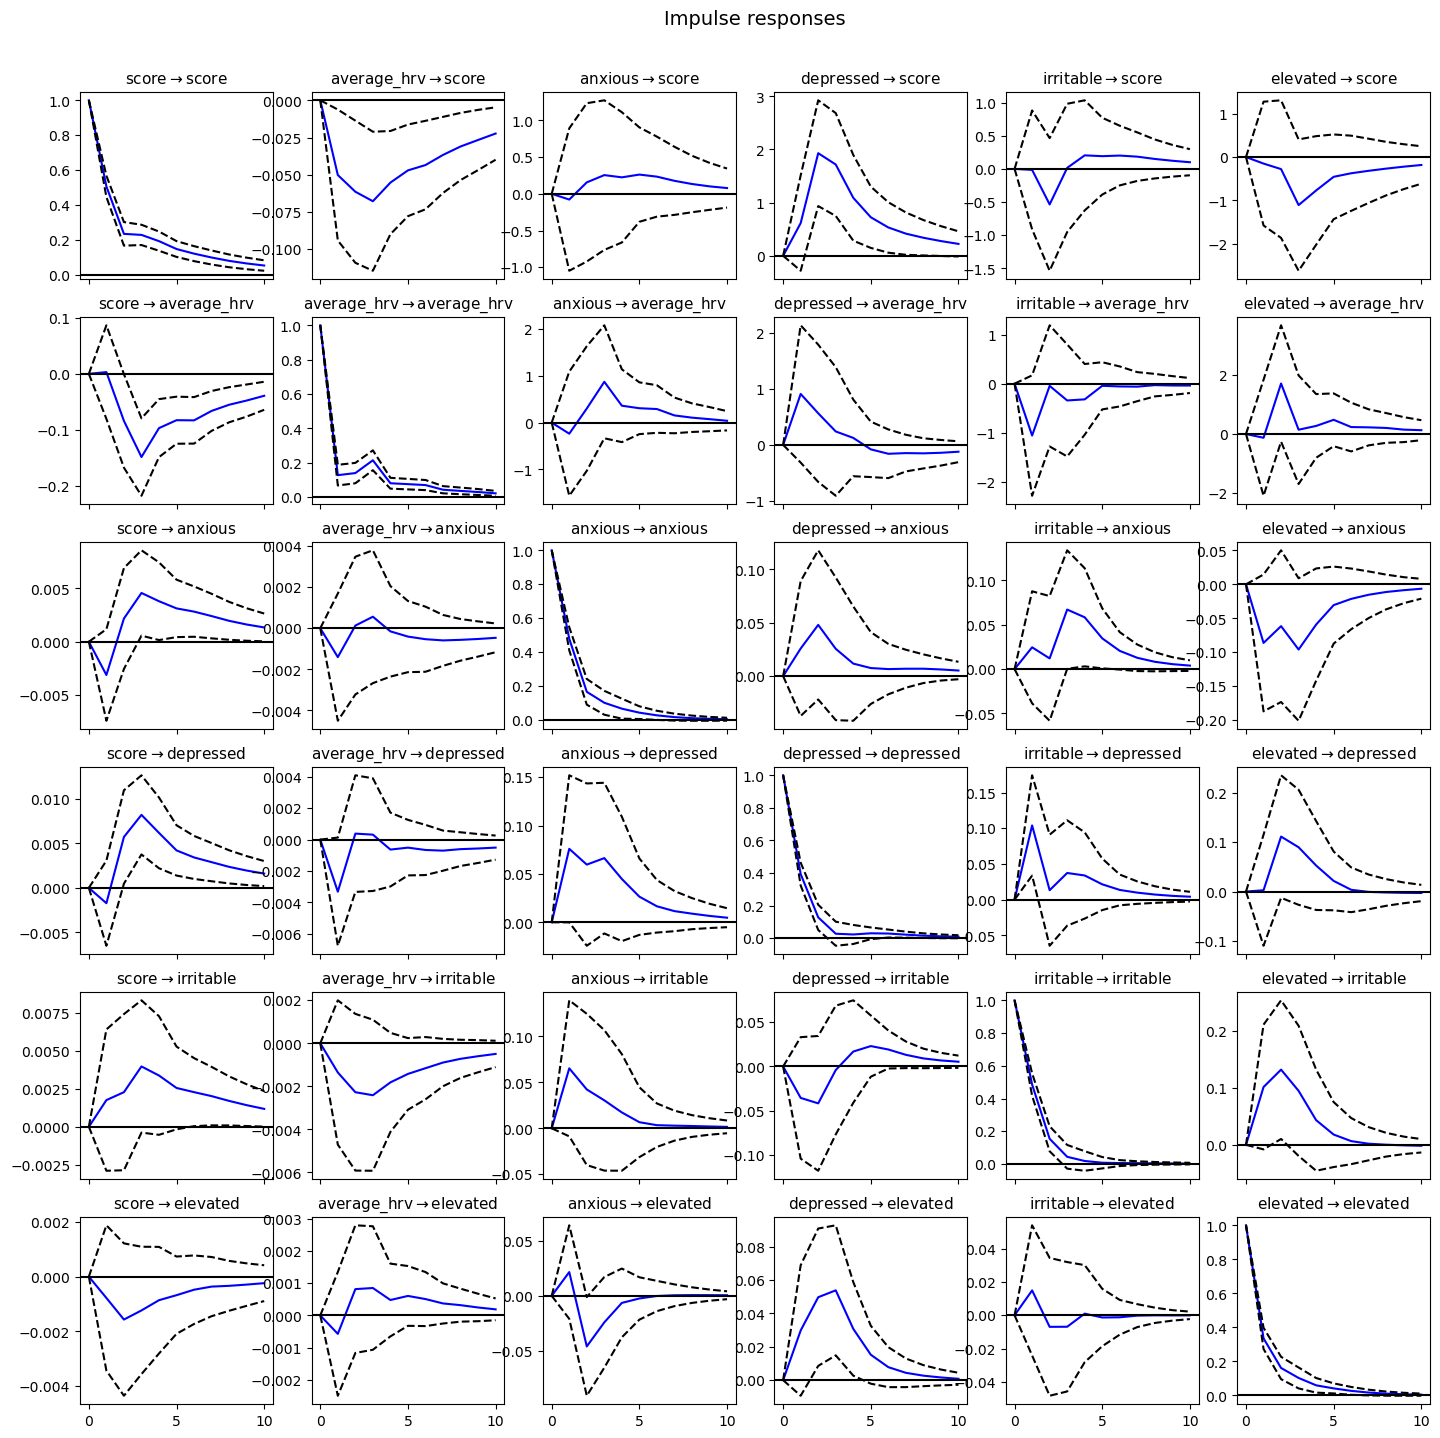

In [30]:
irf = results_var.irf(10)

irf.plot(orth=False, figsize=(15,15), subplot_params={'fontsize': 11}).savefig('plots/IRF.png', dpi=300);

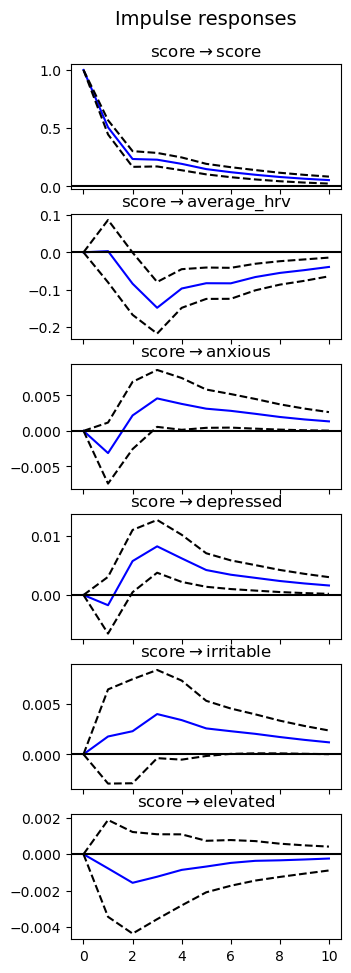

In [33]:
irf.plot(impulse='score', orth=False, figsize=(3,10));